# Task 1 - base resnet

In [59]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import json

In [60]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [61]:
pretrained_model=torchvision.models.resnet34(weights='IMAGENET1K_V1')
pretrained_model.eval().to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [62]:
# Define the preprocessing transformations
mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

In [63]:
dataset_path = "/kaggle/input/testdataset/TestDataSet"
labels_json_path="/kaggle/input/testdataset/TestDataSet/labels_list.json"

In [64]:
dataset = torchvision.datasets.ImageFolder("/kaggle/input/testdataset/TestDataSet", transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2)

In [65]:
index_to_folder = {v: k for k, v in dataset.class_to_idx.items()}
index_to_folder

{0: 'n02672831',
 1: 'n02676566',
 2: 'n02687172',
 3: 'n02690373',
 4: 'n02692877',
 5: 'n02699494',
 6: 'n02701002',
 7: 'n02704792',
 8: 'n02708093',
 9: 'n02727426',
 10: 'n02730930',
 11: 'n02747177',
 12: 'n02749479',
 13: 'n02769748',
 14: 'n02776631',
 15: 'n02777292',
 16: 'n02782093',
 17: 'n02783161',
 18: 'n02786058',
 19: 'n02787622',
 20: 'n02788148',
 21: 'n02790996',
 22: 'n02791124',
 23: 'n02791270',
 24: 'n02793495',
 25: 'n02794156',
 26: 'n02795169',
 27: 'n02797295',
 28: 'n02799071',
 29: 'n02802426',
 30: 'n02804414',
 31: 'n02804610',
 32: 'n02807133',
 33: 'n02808304',
 34: 'n02808440',
 35: 'n02814533',
 36: 'n02814860',
 37: 'n02815834',
 38: 'n02817516',
 39: 'n02823428',
 40: 'n02823750',
 41: 'n02825657',
 42: 'n02834397',
 43: 'n02835271',
 44: 'n02837789',
 45: 'n02840245',
 46: 'n02841315',
 47: 'n02843684',
 48: 'n02859443',
 49: 'n02860847',
 50: 'n02865351',
 51: 'n02869837',
 52: 'n02870880',
 53: 'n02871525',
 54: 'n02877765',
 55: 'n02879718',
 5

In [66]:

with open(labels_json_path) as f:
    label_lines = json.load(f)  # ["401: accordion", "402: acoustic guitar", ...]

# Step 2: Extract ImageNet indices from the list (by position)
imagenet_indices = [int(line.split(":")[0]) for line in label_lines]

# Step 3: Build folder_to_imagenet_id using index-to-folder mapping
folder_to_imagenet_id = {
    index_to_folder[i]: imagenet_indices[i]
    for i in range(len(imagenet_indices))
}


In [67]:
correct_top1 = 0
correct_top5 = 0
total = 0


In [68]:

# Evaluation loop
with torch.no_grad():
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = pretrained_model(inputs)
        _, top5_predicted = outputs.topk(5, 1, True, True)

        for i in range(inputs.size(0)):
            label_idx = labels[i].item()  # index like 0, 1, ...
            folder_name = index_to_folder[label_idx]  # e.g., 'n02672831'
            true_class_idx = folder_to_imagenet_id.get(folder_name)

            if true_class_idx is None:
                print(f"⚠️ Folder '{folder_name}' not found in mapping.")
                continue

            preds = top5_predicted[i].tolist()

            if preds[0] == true_class_idx:
                correct_top1 += 1
            if true_class_idx in preds:
                correct_top5 += 1

        total += inputs.size(0)



In [69]:
# Calculate top-1 and top-5 accuracy
top1_accuracy = correct_top1 / total
top5_accuracy = correct_top5 / total

print(f"Top-1 Accuracy: {top1_accuracy * 100:.2f}%")
print(f"Top-5 Accuracy: {top5_accuracy * 100:.2f}%")


Top-1 Accuracy: 70.40%
Top-5 Accuracy: 93.20%


## Task 2 -  fgsm - simple attack

In [70]:
import torch.nn.functional as F

def fgsm_attack(image, label, model, epsilon):
    image.requires_grad = True
    output = model(image)
    loss = F.cross_entropy(output, label)
    model.zero_grad()
    loss.backward()
    data_grad = image.grad.data

    # Generate perturbed image
    perturbed_image = image + epsilon * data_grad.sign()
    perturbed_image = torch.clamp(perturbed_image, 0, 1)  # keep values in [0, 1]
    return perturbed_image.detach()


In [82]:
epsilon=0.02
adv_images=[]
adv_labels=[]

pretrained_model.eval()

for inputs,labels in dataloader:
    inputs,labels=inputs.to(device),labels.to(device)
    for i in range(inputs.size(0)):
        img = inputs[i].unsqueeze(0) 
        label = labels[i].unsqueeze(0)
        adv_img = fgsm_attack(img, label, pretrained_model, epsilon)
        adv_images.append(adv_img.cpu())
        adv_labels.append(label.cpu())


In [83]:
import torch.utils.data as data
adv_images_tensor = torch.cat(adv_images)
adv_labels_tensor = torch.cat(adv_labels)
adv_dataset= data.TensorDataset(adv_images_tensor,adv_labels_tensor)
torch.save(adv_dataset,"AdversarialTestSet1.pt")

In [84]:
adv_loader= DataLoader(adv_dataset, batch_size=32,shuffle=False)
correct_top1 = 0
correct_top5 = 0
total = 0

In [85]:
with torch.no_grad():
    for inputs, labels in adv_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = pretrained_model(inputs)
        _, top5_predicted = outputs.topk(5, 1, True, True)

        for i in range(inputs.size(0)):
            folder_name = index_to_folder[labels[i].item()]
            true_class_idx = folder_to_imagenet_id.get(folder_name)

            preds = top5_predicted[i].tolist()
            if preds[0] == true_class_idx:
                correct_top1 += 1
            if true_class_idx in preds:
                correct_top5 += 1

        total += inputs.size(0)

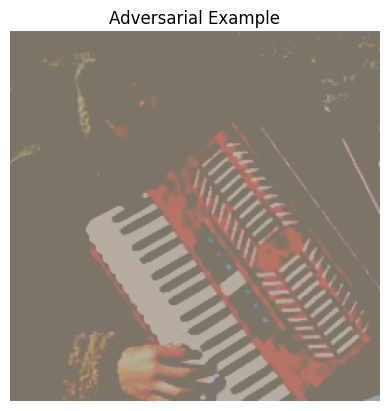

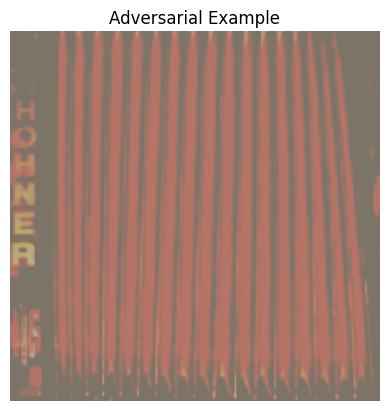

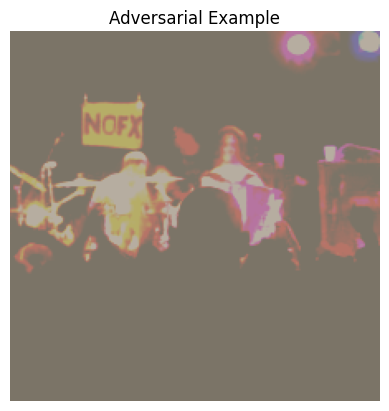

In [86]:
import matplotlib.pyplot as plt

def unnormalize(t):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    return (t * std + mean).clamp(0, 1)

for i in range(3):
    orig = unnormalize(adv_images_tensor[i])
    plt.imshow(orig.permute(1,2,0).numpy())
    plt.title("Adversarial Example")
    plt.axis('off')
    plt.show()


In [87]:
print(f"FGSM Top-1 Accuracy: {correct_top1 / total * 100:.2f}%")
print(f"FGSM Top-5 Accuracy: {correct_top5 / total * 100:.2f}%")

FGSM Top-1 Accuracy: 39.00%
FGSM Top-5 Accuracy: 60.60%


# Task 3- iterative FGSM

In [88]:
import torch.nn.functional as F

def iterative_fgsm(image, label, model, epsilon=0.02, alpha=0.005, steps=10):
    original_image = image.clone().detach()
    adv_image = image.clone().detach().requires_grad_(True)

    for _ in range(steps):
        output = model(adv_image)
        loss = F.cross_entropy(output, label)
        model.zero_grad()
        loss.backward()

        # Gradient step
        adv_image = adv_image + alpha * adv_image.grad.sign()

        # Project back to ε-ball and clip to valid image range
        perturbation = torch.clamp(adv_image - original_image, min=-epsilon, max=epsilon)
        adv_image = torch.clamp(original_image + perturbation, 0, 1).detach()
        adv_image.requires_grad_()

    return adv_image


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [89]:
improved_adv_images = []
improved_adv_labels = []

for inputs, labels in dataloader:
    inputs, labels = inputs.to(device), labels.to(device)

    for i in range(inputs.size(0)):
        img = inputs[i].unsqueeze(0)
        label = labels[i].unsqueeze(0)

        adv_img = iterative_fgsm(img, label, pretrained_model, epsilon=0.02, alpha=0.005, steps=10)
        improved_adv_images.append(adv_img.cpu())
        improved_adv_labels.append(label.cpu())


In [90]:
import torch.utils.data as data

adv_images_tensor = torch.cat(improved_adv_images)
adv_labels_tensor = torch.cat(improved_adv_labels)

adv_dataset_2 = data.TensorDataset(adv_images_tensor, adv_labels_tensor)
torch.save(adv_dataset_2, "AdversarialTestSet2.pt")


In [91]:
adv_loader = DataLoader(adv_dataset_2, batch_size=32, shuffle=False)

correct_top1, correct_top5, total = 0, 0, 0

with torch.no_grad():
    for inputs, labels in adv_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = pretrained_model(inputs)
        _, top5_predicted = outputs.topk(5, 1, True, True)

        for i in range(inputs.size(0)):
            folder_name = index_to_folder[labels[i].item()]
            true_class_idx = folder_to_imagenet_id.get(folder_name)

            preds = top5_predicted[i].tolist()
            if preds[0] == true_class_idx:
                correct_top1 += 1
            if true_class_idx in preds:
                correct_top5 += 1

        total += inputs.size(0)

print(f"Improved Attack - Top-1 Accuracy: {correct_top1 / total * 100:.2f}%")
print(f"Improved Attack - Top-5 Accuracy: {correct_top5 / total * 100:.2f}%")


Improved Attack - Top-1 Accuracy: 38.20%
Improved Attack - Top-5 Accuracy: 53.80%


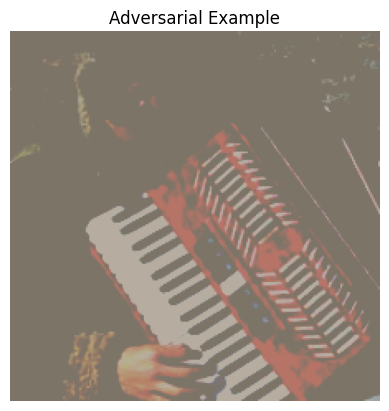

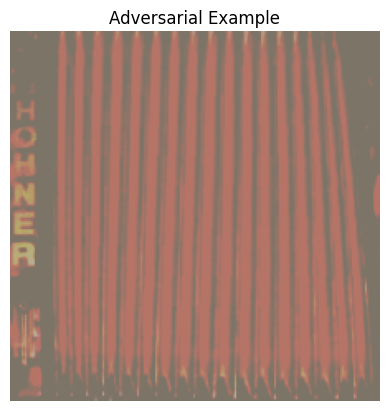

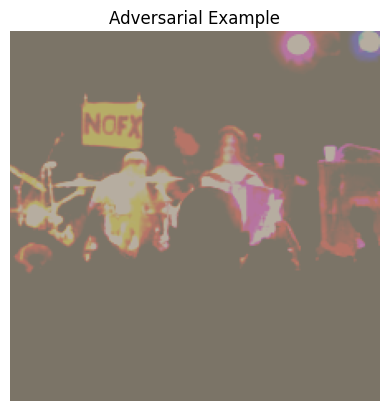

In [93]:
import matplotlib.pyplot as plt

def unnormalize(t):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    return (t * std + mean).clamp(0, 1)

for i in range(3):
    orig = unnormalize(adv_images_tensor[i])
    plt.imshow(orig.permute(1,2,0).detach().numpy())
    plt.title("Adversarial Example")
    plt.axis('off')
    plt.show()


# Task 4- patch wise fgsm

In [102]:
def patch_attack(image, label, model, epsilon=0.3, alpha=0.03, steps=10, patch_size=32, x=None, y=None):
    image = image.clone().detach()
    original = image.clone().detach()
    image.requires_grad = True

    _, _, h, w = image.shape
    if x is None:
        x = random.randint(0, w - patch_size)
    if y is None:
        y = random.randint(0, h - patch_size)

    for _ in range(steps):
        output = model(image)
        loss = F.cross_entropy(output, label)
        model.zero_grad()
        loss.backward()

        grad = image.grad.data
        image.data[:, :, y:y+patch_size, x:x+patch_size] += alpha * grad[:, :, y:y+patch_size, x:x+patch_size].sign()

        diff = image.data - original
        diff = torch.clamp(diff, min=-epsilon, max=epsilon)
        image.data = torch.clamp(original + diff, 0, 1)
        image.grad.zero_()

    return image.detach()


In [103]:
patch_x_coords = []
patch_y_coords = []
adv_images = []
adv_labels = []
original_images = []

for inputs, labels in dataloader:
    inputs, labels = inputs.to(device), labels.to(device)

    for i in range(inputs.size(0)):
        img = inputs[i].unsqueeze(0)
        label = labels[i].unsqueeze(0)

        # Select random patch coordinates
        _, _, h, w = img.shape
        x = random.randint(0, w - 32)
        y = random.randint(0, h - 32)

        # Save original image
        original_images.append(img.squeeze(0).cpu())

        # Call patch attack, pass (x, y)
        adv_img = patch_attack(img, label, pretrained_model,
                               epsilon=0.3, alpha=0.03, steps=10,
                               patch_size=32, x=x, y=y)

        adv_images.append(adv_img.squeeze(0).cpu())
        adv_labels.append(label.cpu())
        patch_x_coords.append(x)
        patch_y_coords.append(y)


In [107]:
import matplotlib.pyplot as plt
import torch

def unnormalize(img):
    # For ImageNet normalization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return (img * std + mean).clamp(0, 1)

def show_patch_attack(orig_img_tensor, adv_img_tensor, x, y, patch_size=32, title=None):
    orig_img = unnormalize(orig_img_tensor.detach()).permute(1, 2, 0).cpu().numpy()
    adv_img = unnormalize(adv_img_tensor.detach()).permute(1, 2, 0).cpu().numpy()

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    axs[0].imshow(orig_img)
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    axs[1].imshow(adv_img)
    axs[1].add_patch(plt.Rectangle((x, y), patch_size, patch_size,
                                   edgecolor='red', facecolor='none', lw=2))
    axs[1].set_title("Adversarial (with patch)")
    axs[1].axis('off')

    if title:
        plt.suptitle(title)

    plt.tight_layout()
    plt.show()


In [105]:
adv_loader = DataLoader(adv_patchset, batch_size=32, shuffle=False)

correct_top1, correct_top5, total = 0, 0, 0

with torch.no_grad():
    for inputs, labels in adv_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = pretrained_model(inputs)
        _, top5_predicted = outputs.topk(5, 1, True, True)

        for i in range(inputs.size(0)):
            folder_name = index_to_folder[labels[i].item()]
            true_class_idx = folder_to_imagenet_id.get(folder_name)

            preds = top5_predicted[i].tolist()
            if preds[0] == true_class_idx:
                correct_top1 += 1
            if true_class_idx in preds:
                correct_top5 += 1

        total += inputs.size(0)

print(f"Improved Attack - Top-1 Accuracy: {correct_top1 / total * 100:.2f}%")
print(f"Improved Attack - Top-5 Accuracy: {correct_top5 / total * 100:.2f}%")


Improved Attack - Top-1 Accuracy: 35.20%
Improved Attack - Top-5 Accuracy: 54.20%


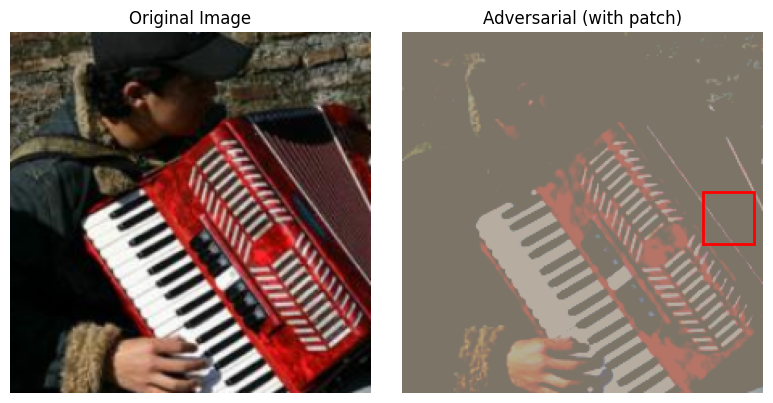

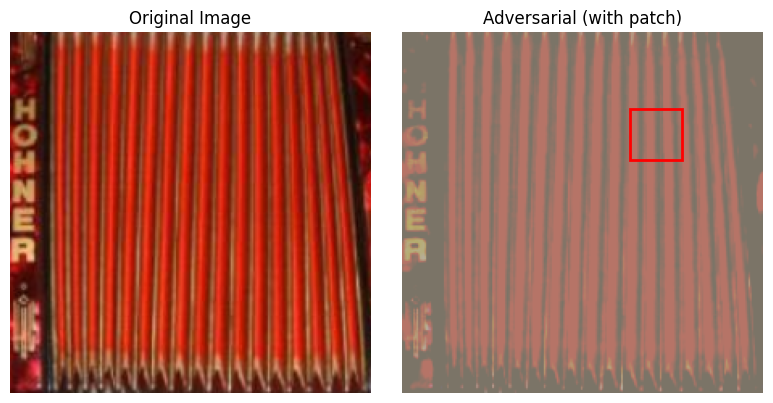

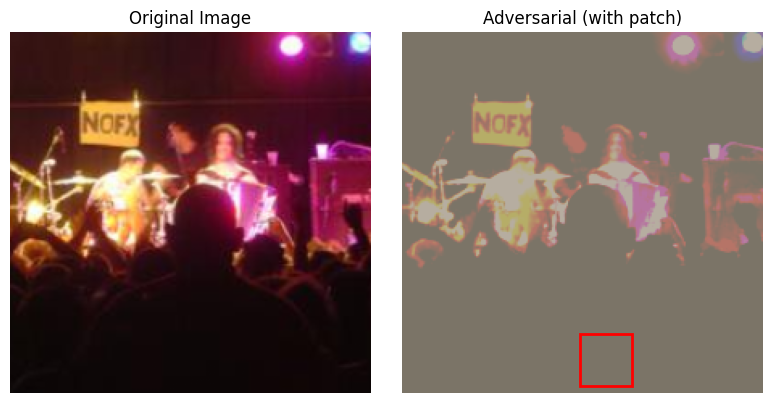

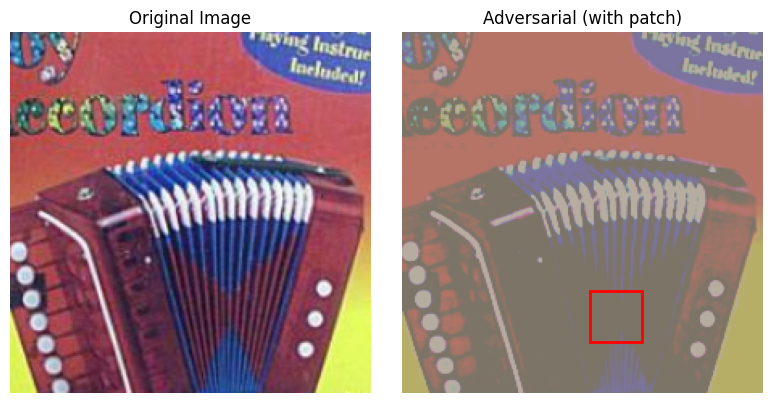

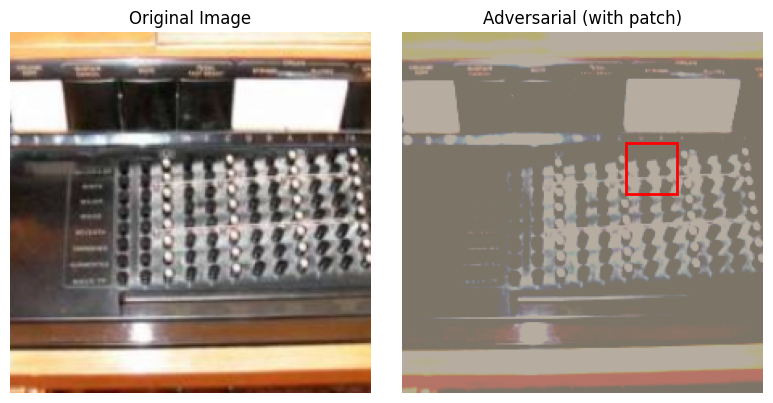

In [109]:
# Example: visualizing the 5th image
for i in range(5):
    show_patch_attack(orig_img_tensor=original_images[i],
                  adv_img_tensor=adv_images_tensor[i],
                  x=patch_x_coords[i],
                  y=patch_y_coords[i])


# Task 5- Transferring attacks

In [110]:
import torchvision.models as models

new_model = models.densenet121(weights='IMAGENET1K_V1')
new_model = new_model.to(device)
new_model.eval()


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 173MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [111]:
original_loader = DataLoader(original_dataset, batch_size=32, shuffle=False)
adv_loader_1 = DataLoader(torch.load("AdversarialTestSet1.pt"), batch_size=32, shuffle=False)
adv_loader_2 = DataLoader(torch.load("AdversarialTestSet2.pt"), batch_size=32, shuffle=False)
adv_loader_3 = DataLoader(torch.load("AdversarialTestSet3.pt"), batch_size=32, shuffle=False)


/tmp/ipykernel_31/960681015.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  adv_loader_1 = DataLoader(torch.load("AdversarialTestSet1.pt"), batch_size=32, shuffle=False)

In [112]:
def evaluate_topk(model, dataloader, index_to_folder, folder_to_imagenet_id):
    correct_top1, correct_top5, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, top5_predicted = outputs.topk(5, 1, True, True)

            for i in range(inputs.size(0)):
                folder_name = index_to_folder[labels[i].item()]
                true_idx = folder_to_imagenet_id.get(folder_name)

                if true_idx is None:
                    continue

                preds = top5_predicted[i].tolist()
                if preds[0] == true_idx:
                    correct_top1 += 1
                if true_idx in preds:
                    correct_top5 += 1
            total += inputs.size(0)
    return correct_top1 / total * 100, correct_top5 / total * 100


In [113]:
datasets = {
    "Original": original_loader,
    "Adversarial Set 1 (FGSM)": adv_loader_1,
    "Adversarial Set 2 (Iterative)": adv_loader_2,
    "Adversarial Set 3 (Patch)": adv_loader_3
}

for name, loader in datasets.items():
    top1, top5 = evaluate_topk(new_model, loader, index_to_folder, folder_to_imagenet_id)
    print(f"{name} - Top-1 Accuracy: {top1:.2f}%, Top-5 Accuracy: {top5:.2f}%")


Original - Top-1 Accuracy: 70.80%, Top-5 Accuracy: 91.20%
Adversarial Set 1 (FGSM) - Top-1 Accuracy: 41.00%, Top-5 Accuracy: 67.00%
Adversarial Set 2 (Iterative) - Top-1 Accuracy: 43.00%, Top-5 Accuracy: 65.60%
Adversarial Set 3 (Patch) - Top-1 Accuracy: 40.60%, Top-5 Accuracy: 65.20%
